The data `Xtrainphoneme` and `Ztrainphoneme` come from the linear model $$E[Z_i | X_i=x] = \alpha + \beta^T x_i$$
where $p=256$ and $n=300$. We are asked to predict the value of $Z$ for the new 1417 obersvations in `Xtestphoneme` using the standard LS predictor, as well as uing the PC predictor for $q=2,\dots,10$.

The true values are available in `Ztestphoneme`

In [1]:
!dir C:\Users\seanl\multivariate-statistics\notebooks\data-sets

 Volume in drive C has no label.
 Volume Serial Number is ACB5-FD94

 Directory of C:\Users\seanl\multivariate-statistics\notebooks\data-sets

07/09/2025  02:02 PM    <DIR>          .
07/09/2025  04:34 PM    <DIR>          ..
07/09/2025  12:22 PM            12,925 boston_housing.csv
07/09/2025  12:22 PM             7,607 swiss_bank_notes.csv
07/09/2025  02:02 PM         3,227,224 Xtestphoneme.txt
07/09/2025  02:02 PM           683,249 Xtrainphoneme.txt
07/09/2025  02:02 PM            14,024 Ztestphoneme.txt
07/09/2025  02:02 PM             2,968 Ztrainphoneme.txt
               6 File(s)      3,947,997 bytes
               2 Dir(s)  402,558,771,200 bytes free


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [3]:
X_train = pd.read_csv('data-sets\Xtrainphoneme.txt', header=None).to_numpy()
X_train = np.delete(X_train, -1, axis=-1)
Z_train = pd.read_csv('data-sets\Ztrainphoneme.txt', header=None).to_numpy().T

X_test = pd.read_csv('data-sets\Xtestphoneme.txt', header=None).to_numpy()
X_test = np.delete(X_test, -1, axis=-1)
Z_test = pd.read_csv('data-sets\Ztestphoneme.txt', header=None).to_numpy().T

In [4]:
assert X_train.shape == (300, 256)  # check that we have the expected shape
assert Z_train.shape == (300, 1)

assert X_test.shape == (1417, 256)
assert Z_test.shape == (1417, 1)

#### Standard LS Prediction

#### Using PC Regression

We now perform PCR for $q=2,\dots,10$ PC's. 

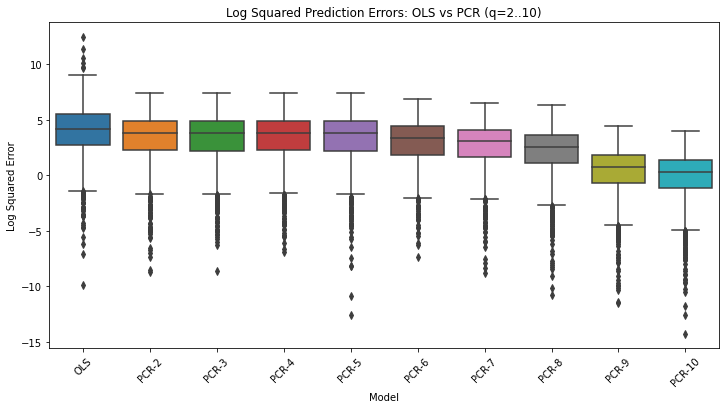

In [5]:
# Center predictors like in R (no scaling, just centering)
scaler = StandardScaler(with_mean=True, with_std=False)
X_train_cent = scaler.fit_transform(X_train)
X_test_cent  = scaler.transform(X_test)

Z_train_cent = Z_train - Z_train.mean()
Z_test_cent  = Z_test - Z_train.mean()   # center with training mean

# --- OLS ---
ols_model = LinearRegression(fit_intercept=False)  # already centered
ols_model.fit(X_train_cent, Z_train_cent)
ols_preds_cent = ols_model.predict(X_test_cent)
ols_preds = Z_train.mean() + ols_preds_cent   # add mean back

ols_errors = ols_preds - Z_test
ols_log_errors = np.log(ols_errors**2 + 1e-8)

results = [pd.DataFrame({
    "Log Squared Error": np.ndarray.flatten(ols_log_errors),
    "Model": "OLS"
})]

# --- PCR ---
for q in range(2, 11):
    pca = PCA(n_components=q)
    X_train_reduced = pca.fit_transform(X_train_cent)
    X_test_reduced  = pca.transform(X_test_cent)

    pc_model = LinearRegression(fit_intercept=False)
    pc_model.fit(X_train_reduced, Z_train_cent)
    
    preds_cent = pc_model.predict(X_test_reduced)
    preds = Z_train.mean() + preds_cent
    
    errors = preds - Z_test
    log_errors = np.log(errors**2 + 1e-8)
    
    results.append(pd.DataFrame({
        "Log Squared Error": np.ndarray.flatten(log_errors),
        "Model": f"PCR-{q}"
    }))

results_df = pd.concat(results, ignore_index=True)

plt.figure(figsize=(12,6))
sns.boxplot(x="Model", y="Log Squared Error", data=results_df)
plt.xticks(rotation=45)
plt.title("Log Squared Prediction Errors: OLS vs PCR (q=2..10)")
plt.show()

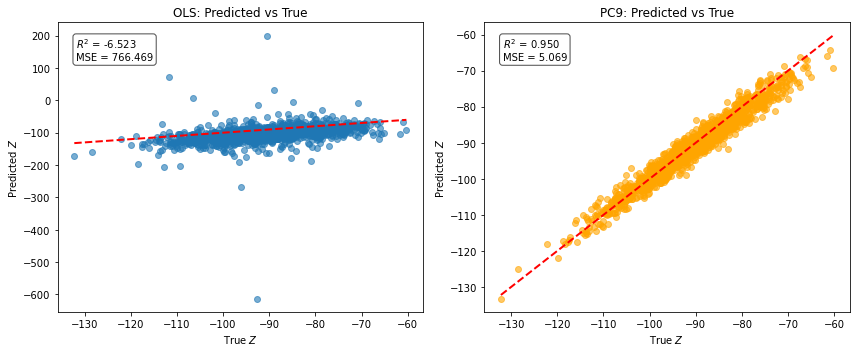

In [8]:
# ---- OLS Predictions ----
ols_preds = ols_model.predict(X_test)
ols_r2  = r2_score(Z_test, ols_preds)
ols_mse = mean_squared_error(Z_test, ols_preds)


# ---- PC6 Predictions ----
pca9 = PCA(n_components=9)
X_train_pca9 = pca9.fit_transform(X_train)
X_test_pca9  = pca9.transform(X_test)

pc9_model = LinearRegression().fit(X_train_pca9, Z_train)
pc9_preds = pc9_model.predict(X_test_pca9)

pc9_r2  = r2_score(Z_test, pc9_preds)
pc9_mse = mean_squared_error(Z_test, pc9_preds)


# ---- Plot ----
plt.figure(figsize=(12,5))

# OLS
plt.subplot(1,2,1)
plt.scatter(Z_test, ols_preds, alpha=0.6)
plt.plot([Z_test.min(), Z_test.max()],
         [Z_test.min(), Z_test.max()],
         'r--', lw=2)
plt.xlabel("True $Z$")
plt.ylabel("Predicted $Z$")
plt.title("OLS: Predicted vs True")
plt.text(0.05, 0.95,
         f"$R^2$ = {ols_r2:.3f}\nMSE = {ols_mse:.3f}",
         transform=plt.gca().transAxes,
         fontsize=10, va="top", ha="left",
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# PC6
plt.subplot(1,2,2)
plt.scatter(Z_test, pc9_preds, alpha=0.6, color='orange')
plt.plot([Z_test.min(), Z_test.max()],
         [Z_test.min(), Z_test.max()],
         'r--', lw=2)
plt.xlabel("True $Z$")
plt.ylabel("Predicted $Z$")
plt.title("PC9: Predicted vs True")
plt.text(0.05, 0.95,
         f"$R^2$ = {pc9_r2:.3f}\nMSE = {pc9_mse:.3f}",
         transform=plt.gca().transAxes,
         fontsize=10, va="top", ha="left",
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.tight_layout()